# Hyperlocal Forecasting with FBProphet

In [2]:
!pip3 install pygeohash

  Stored in directory: /root/.cache/pip/wheels/3f/5f/14/989d83a271207dda28232746d63e737a2dbd88ea7f7a9db807
Successfully built pygeohash


In [ ]:
import math
import datetime

import numpy as np
import pandas as pd
import pygeohash as gh
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from sklearn.metrics import mean_squared_error

import _pickle as cPickle

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
sns.set(style="whitegrid")

## The data

### Load preprocessed data

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
cd 'gdrive/My Drive/Colab Notebooks/aiforsea'

/content/gdrive/My Drive/Colab Notebooks/aiforsea


In [6]:
df = pd.read_csv('full_data.csv')
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude
0,qp02yc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.653687
1,qp02z1,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.664673
2,qp02z3,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.675659
3,qp02z9,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.686646
4,qp02zc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.697632


### Add fbprophet info

In [ ]:
def is_weekend(day):
    if type(day) != int:
        day = int(pd.to_datetime(day).day)
    day %= 7
    return (4 <= day <= 5)

In [8]:
%%time
df['is_weekend'] = (4 <= (df['day'].values % 7 )) & ((df['day'].values % 7) <= 5)
df['is_weekday'] = ~(df['is_weekend'])

CPU times: user 227 ms, sys: 4.05 ms, total: 231 ms
Wall time: 232 ms


In [ ]:
df['cap'] = 1.0
df['floor'] = 0.0

In [10]:
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude,is_weekend,is_weekday,cap,floor
0,qp02yc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.653687,False,True,1.0,0.0
1,qp02z1,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.664673,False,True,1.0,0.0
2,qp02z3,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.675659,False,True,1.0,0.0
3,qp02z9,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.686646,False,True,1.0,0.0
4,qp02zc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.697632,False,True,1.0,0.0


### Collect information for each location

In [11]:
locations = df['geohash6'].unique()
print(len(locations), locations)

1329 ['qp02yc' 'qp02z1' 'qp02z3' ... 'qp0djw' 'qp0djy' 'qp0dnn']


In [ ]:
df_locinfo = pd.DataFrame()
df_locinfo['median'] = df.groupby(['geohash6'])['demand'].median()
df_locinfo['mean'] = df.groupby(['geohash6'])['demand'].mean()
df_locinfo['count'] = df.groupby(['geohash6'])['demand'].count()

df_locinfo = df_locinfo.sort_values(by=['mean', 'median'])

In [13]:
df_locinfo.iloc[int(0.95*len(locations))]
# df_locinfo.iloc[len(locations)//2:len(locations)//2+5]
#df_locinfo.head()

median       0.245194
mean         0.237392
count     5856.000000
Name: qp096w, dtype: float64

## Predict in one location

### Get relevant data

- rmse with 14-day training time: 0.014642195942103692
- rmse with 61-day training time: 0.016393733352326783
- rmse with full data:            0.019973121016863295

In [14]:
df_fb = df[df['geohash6'] == 'qp096w'].reset_index().drop('index', axis=1)
df_fb = df_fb[df_fb['day'] >= 61-14].reset_index().drop('index', axis=1)
df_fb = df_fb.rename(columns={'demand' : 'y'}).drop(['geohash6', 'in_raw',
                                                     'weekday', 'hour', 'minutes',
                                                     'day', 'latitude', 'longitude'], axis=1)
df_fb.head()

,y,ds,is_weekend,is_weekday,cap,floor
0,0.045129,1900-02-16 00:00:00,True,False,1.0,0.0
1,0.081951,1900-02-16 00:15:00,True,False,1.0,0.0
2,0.065130,1900-02-16 00:30:00,True,False,1.0,0.0
3,0.193261,1900-02-16 00:45:00,True,False,1.0,0.0
4,0.171539,1900-02-16 01:00:00,True,False,1.0,0.0


In [ ]:
# %%time
# df_fb = df[df['geohash6'] == 'qp096w'].groupby(['day', 'ds'])['demand'].mean().reset_index()
# df_fb = df_fb[df_fb['day'] >= 61-14].reset_index().drop('index', axis=1)
# df_fb = df_fb.rename(columns={'demand' : 'y'}).drop(['day'], axis=1)
# 
# df_fb['cap']   = 1.0
# df_fb['floor'] = 0.0
# 
# df_fb['is_weekend'] = df_fb['ds'].apply(is_weekend)
# df_fb['is_weekday'] = ~df_fb['ds'].apply(is_weekend)

In [16]:
df_fb.head()

,y,ds,is_weekend,is_weekday,cap,floor
0,0.045129,1900-02-16 00:00:00,True,False,1.0,0.0
1,0.081951,1900-02-16 00:15:00,True,False,1.0,0.0
2,0.065130,1900-02-16 00:30:00,True,False,1.0,0.0
3,0.193261,1900-02-16 00:45:00,True,False,1.0,0.0
4,0.171539,1900-02-16 01:00:00,True,False,1.0,0.0


### Create and train the model

In [17]:
m = Prophet(
        growth='logistic',
        seasonality_mode='multiplicative',
        daily_seasonality=False,
        uncertainty_samples=100
    ).add_seasonality(
        name='weekday_daily',
        period=1,
        fourier_order=12,
        condition_name='is_weekday'
    ).add_seasonality(
        name='weekend_daily',
        period=1,
        fourier_order=12,
        condition_name='is_weekend'
    )

m.fit(df_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Forecast

In [18]:
future = m.make_future_dataframe(periods=5, freq='15min')

future['cap'] = 1.0
future['floor'] = 0.0

future['is_weekend'] = future['ds'].apply(is_weekend)
future['is_weekday'] = ~future['ds'].apply(is_weekend)

future.tail()

,ds,cap,floor,is_weekend,is_weekday
1440,1900-03-03 00:00:00,1.0,0.0,False,True
1441,1900-03-03 00:15:00,1.0,0.0,False,True
1442,1900-03-03 00:30:00,1.0,0.0,False,True
1443,1900-03-03 00:45:00,1.0,0.0,False,True
1444,1900-03-03 01:00:00,1.0,0.0,False,True


In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1440,1900-03-03 00:00:00,0.290961,0.225108,0.371766
1441,1900-03-03 00:15:00,0.307807,0.226014,0.392818
1442,1900-03-03 00:30:00,0.316444,0.224787,0.375289
1443,1900-03-03 00:45:00,0.322374,0.239317,0.402594
1444,1900-03-03 01:00:00,0.330731,0.248233,0.422017


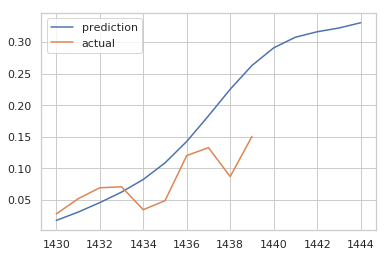

In [30]:
plt.plot(forecast['yhat'].iloc[-15:], label='prediction')
plt.plot(df_fb['y'].iloc[-10:], label='actual')
plt.legend(loc='upper left')

In [21]:
rmse = math.sqrt(mean_squared_error(forecast['yhat'].iloc[-10:-5].values, df_fb['y'].iloc[-5:].values))
print("root_mean_squared_error:", rmse)

root_mean_squared_error: 0.08769441308597882


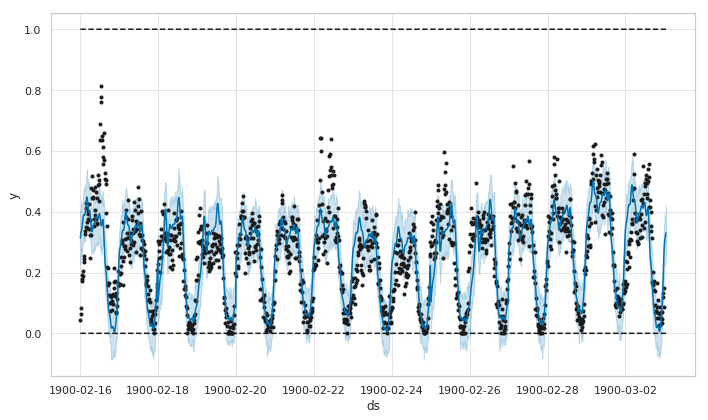

In [22]:
fig1 = m.plot(forecast)

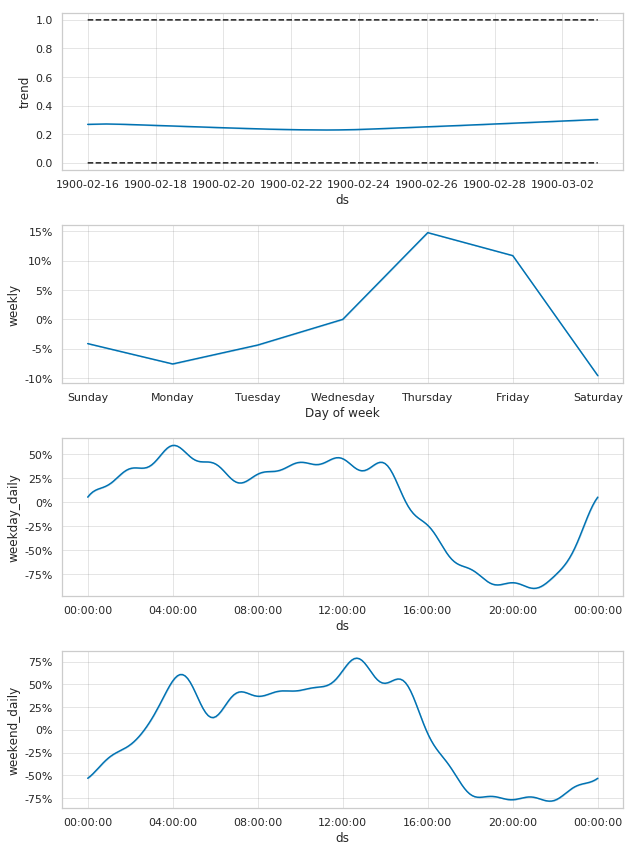

In [23]:
fig2 = m.plot_components(forecast)

## Calculate Mean RMSE in all locations

In [24]:
future = m.make_future_dataframe(periods=5, freq='15min')
future['cap'] = 1.0
future['floor'] = 0.0
future['is_weekend'] = future['ds'].apply(is_weekend)
future['is_weekday'] = ~future['ds'].apply(is_weekend)
future = future.iloc[-10:-5, :]
future

,ds,cap,floor,is_weekend,is_weekday
1435,1900-03-02 22:45:00,1.0,0.0,False,True
1436,1900-03-02 23:00:00,1.0,0.0,False,True
1437,1900-03-02 23:15:00,1.0,0.0,False,True
1438,1900-03-02 23:30:00,1.0,0.0,False,True
1439,1900-03-02 23:45:00,1.0,0.0,False,True


In [25]:
%%time
df_fbc = df[df['day'] >= 61-14].rename(columns={'demand' : 'y'})
gb = df_fbc.groupby('geohash6')    
series = {x : gb.get_group(x) for x in gb.groups}

CPU times: user 2.34 s, sys: 18.5 ms, total: 2.36 s
Wall time: 2.36 s


In [28]:
%%time
from multiprocessing import Pool, cpu_count
import _pickle as cPickle

def run_prophet(series):
    prophet = Prophet(
        growth='logistic',
        seasonality_mode='multiplicative',
        daily_seasonality=False,
        yearly_seasonality=False,
        uncertainty_samples=100
    ).add_seasonality(
        name='weekday_daily',
        period=1,
        fourier_order=6,
        condition_name='is_weekday'
    ).add_seasonality(
        name='weekend_daily',
        period=1,
        fourier_order=6,
        condition_name='is_weekend'
    )
    prophet.fit(series['data'])
    
    with open('models/prophets/prophet@{}.pkl'.format(series['location']), 'wb') as fid:
        cPickle.dump(prophet, fid)

p = Pool(cpu_count())
predictions = p.imap(run_prophet, list({'location':location, 'data':series[location]} for location in locations))
p.close()
p.join()

CPU times: user 2.33 s, sys: 412 ms, total: 2.74 s
Wall time: 9min 3s
